# Image classification

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import zipfile
path_to_zip_file = "sample_data/potsdata.zip"
directory_to_extract_to = "sample_data"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

## Download and explore the dataset

In [ ]:
import pathlib
data_dir = "sample_data/potsdata"
data_dir = pathlib.Path(data_dir)

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

849


Here are some males:

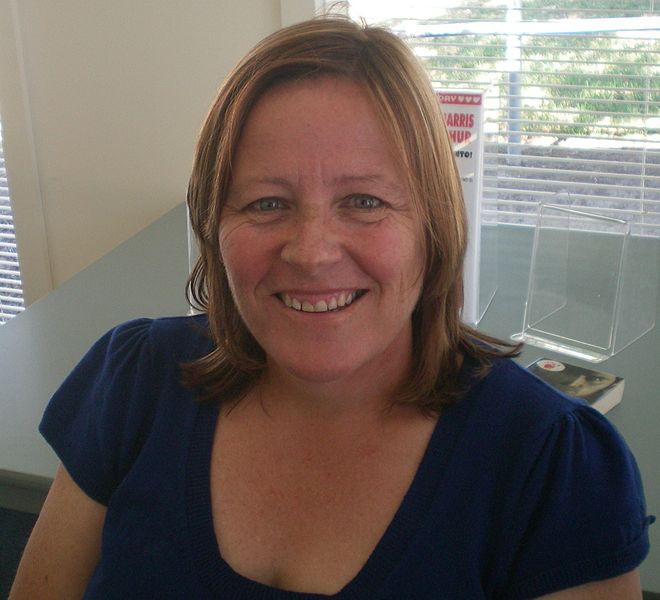

In [ ]:
PIL.Image.open(str(nopots[1]))

And some Females:

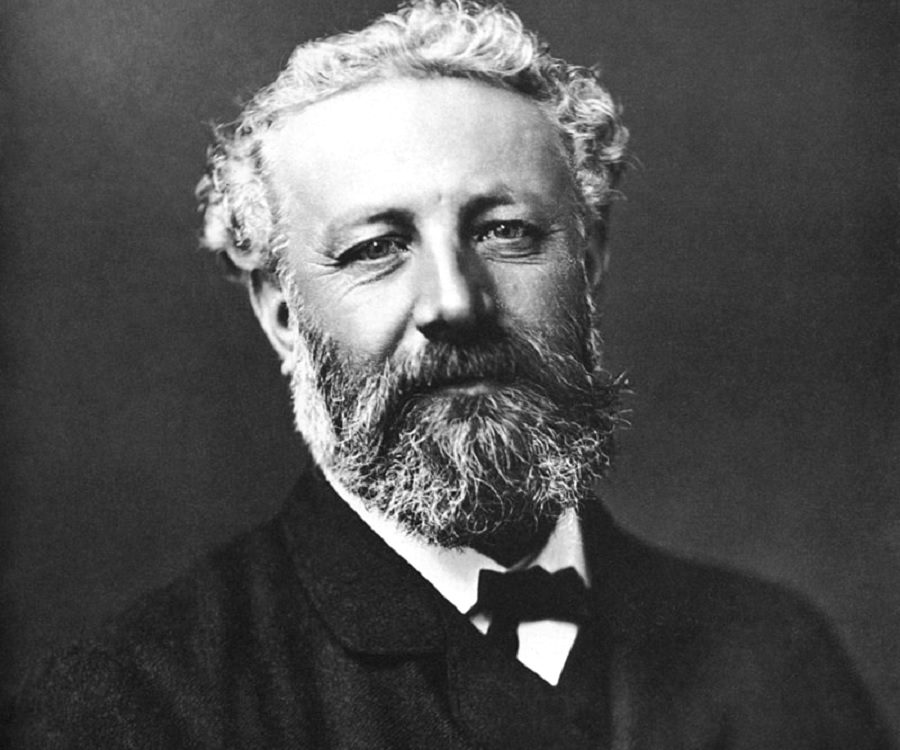

In [ ]:
pots = list(data_dir.glob('pots/*'))
PIL.Image.open(str(pots[0]))

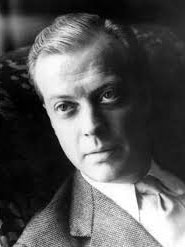

In [ ]:
PIL.Image.open(str(pots[1]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. 

## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 64
img_height = 180
img_width = 180

 use 80% of the images for training, and 20% for validation.

In [ ]:
++++

Found 882 files belonging to 2 classes.
Using 706 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 882 files belonging to 2 classes.
Using 176 files for validation.


 class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['nopots', 'pots']


## Visualize the data

Here are the first nine images from the training dataset:

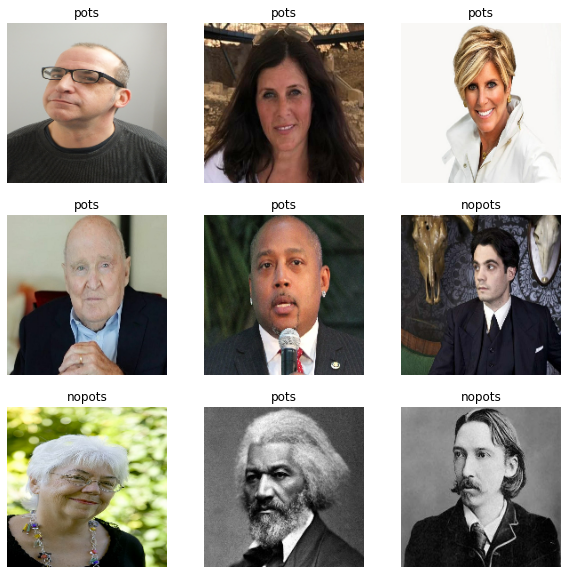

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):\
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Used `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

buffered prefetching without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; so input values small should be small.

standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# Create the model

The Sequential model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`).

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

The `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. 


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
12/12 [==============================] - 14s 154ms/step - loss: 0.7882 - accuracy: 0.4745 - val_loss: 0.6902 - val_accuracy: 0.5568
Epoch 2/10
12/12 [==============================] - 1s 52ms/step - loss: 0.6816 - accuracy: 0.5793 - val_loss: 0.6899 - val_accuracy: 0.5568
Epoch 3/10
12/12 [==============================] - 1s 45ms/step - loss: 0.6627 - accuracy: 0.5921 - val_loss: 0.6367 - val_accuracy: 0.6534
Epoch 4/10
12/12 [==============================] - 1s 45ms/step - loss: 0.6149 - accuracy: 0.6629 - val_loss: 0.5674 - val_accuracy: 0.7330
Epoch 5/10
12/12 [==============================] - 1s 45ms/step - loss: 0.5566 - accuracy: 0.7365 - val_loss: 0.5474 - val_accuracy: 0.7386
Epoch 6/10
12/12 [==============================] - 1s 45ms/step - loss: 0.5219 - accuracy: 0.7436 - val_loss: 0.4933 - val_accuracy: 0.7841
Epoch 7/10
12/12 [==============================] - 1s 45ms/step - loss: 0.4649 - accuracy: 0.7861 - val_loss: 0.5629 - val_accuracy: 0.7216
Epoch 8/10


## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

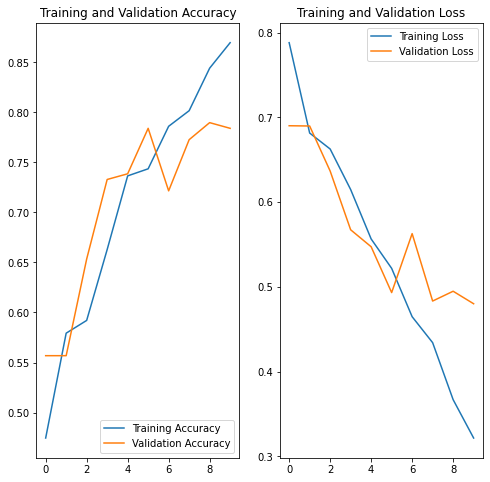

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

## Data augmentation

data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. 

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

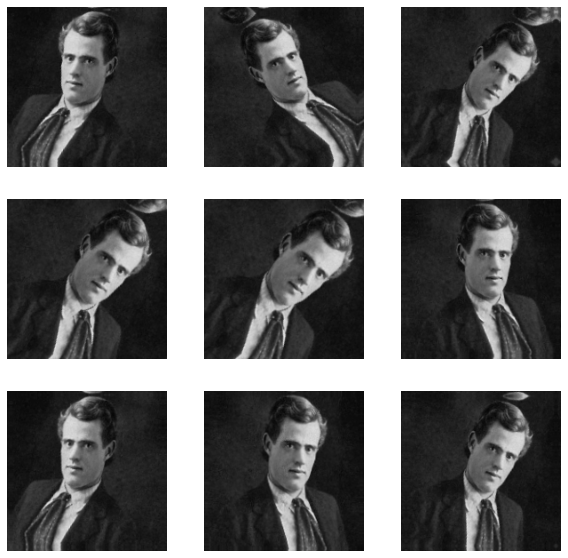

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout



In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
12/12 [==============================] - 2s 65ms/step - loss: 0.8277 - accuracy: 0.4773 - val_loss: 0.6922 - val_accuracy: 0.5739
Epoch 2/50
12/12 [==============================] - 1s 49ms/step - loss: 0.6858 - accuracy: 0.5793 - val_loss: 0.7076 - val_accuracy: 0.5568
Epoch 3/50
12/12 [==============================] - 1s 49ms/step - loss: 0.6810 - accuracy: 0.5793 - val_loss: 0.6866 - val_accuracy: 0.5568
Epoch 4/50
12/12 [==============================] - 1s 48ms/step - loss: 0.6771 - accuracy: 0.5779 - val_loss: 0.6765 - val_accuracy: 0.5909
Epoch 5/50
12/12 [==============================] - 1s 48ms/step - loss: 0.6669 - accuracy: 0.5949 - val_loss: 0.6506 - val_accuracy: 0.6080
Epoch 6/50
12/12 [==============================] - 1s 48ms/step - loss: 0.6531 - accuracy: 0.6091 - val_loss: 0.5906 - val_accuracy: 0.7216
Epoch 7/50
12/12 [==============================] - 1s 52ms/step - loss: 0.6433 - accuracy: 0.6204 - val_loss: 0.5859 - val_accuracy: 0.7443
Epoch 8/50
12

## Visualize training results



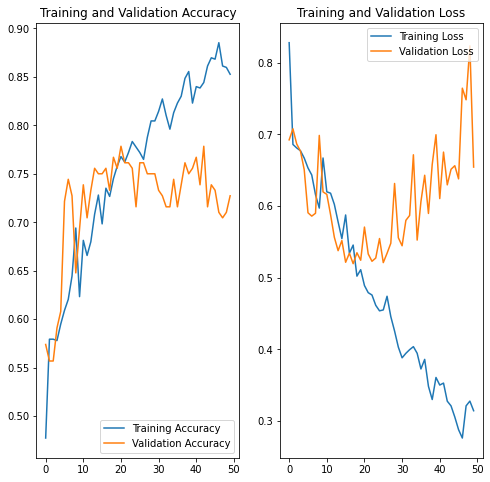

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [ ]:
path_to_test_zip_file = "sample_data/malebiopic.zip"
directory_to_extract_to_test = "sample_data"
with zipfile.ZipFile(path_to_test_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to_test)

In [ ]:
import os

arr = os.listdir('sample_data/malebiopic')
print(arr)

['John Dean.jpg', 'Bramwell Fletcher.jpg', 'George Parker Bidder (marine biologist).jpg', 'Mel Gibson.jpg', 'Joseph Bickersteth Mayor.jpg', 'Paul Boghossian.png', 'Nassim Nicholas Taleb.JPG', 'Stephen King.jpg', 'Steven Laffoley.JPG', 'Tom Clancy.jpg', 'Thomas McGuane.jpg', 'David Attenborough.jpg', 'Christopher Bigsby.jpg', 'Kenneth Arrow.jpg', 'Scott Fauble.jpg', 'Reza Aslan.jpg', "Ed O'Loughlin.jpg", 'G. K. Chesterton.jpg', 'Austin Gary.jpg', 'Lascelles Abercrombie.jpg', 'Lew Rockwell.jpg', 'Peter Benjamin Golden.jpg', 'John Grisham.jpg', 'Mike Judge.jpg', 'James Patterson.jpg', 'Richard T. Wright.jpg', 'Desmond Cole.jpg', 'Mark Spitznagel.jpg', 'John Arthur (philosopher).jpg', 'Peter Levi.jpg', 'Jim Cathcart.jpg', 'Jack Donovan.jpg', 'Michael Bates (Sealand).jpg', 'Jack Williamson.jpg', 'Henry Kissinger.jpg', 'Sam Sykes.jpg', 'David E. Kelley.jpg', 'John Blackner.jpg', 'Patrick Hamilton (writer).jpg', 'Tim LaHaye.jpg', 'David Hoenigman.jpg', 'Patrick Ness.jpg', 'Adam Mansbach.jpg',

In [ ]:
import shutil
nopots_predictions = []
pots_predictions = []
for img in arr:
  print (img)
  test_image_path = "sample_data/malebiopic/"+img
  test_image_pot_result = "sample_data/male pots/"+img
  test_image_nopot_result = "sample_data/male nopots/"+img
  img = tf.keras.utils.load_img(
      test_image_path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if class_names[np.argmax(score)] == "nopots":
    nopots_predictions.append(img)
    shutil.copy(test_image_path, test_image_nopot_result)
  else:
    pots_predictions.append(img)
    shutil.copy(test_image_path, test_image_pot_result)
  print(
      "This image {} most likely belongs to {} with a {:.2f} percent confidence." 
      .format(img,class_names[np.argmax(score)], 100 * np.max(score))
  )

print("=== Result ====")
print("Total nopots_predictions Predictions in percentage = "+str((len(nopots_predictions)/len(arr) * 100)))
print("Total pots_predictions Predictions in percentage = "+str((len(pots_predictions)/len(arr) * 100)))

John Dean.jpg
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F38F61C3210> most likely belongs to nopots with a 99.98 percent confidence.
Bramwell Fletcher.jpg
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F39600AB7D0> most likely belongs to pots with a 99.78 percent confidence.
George Parker Bidder (marine biologist).jpg
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F38E30AA2D0> most likely belongs to nopots with a 98.02 percent confidence.
Mel Gibson.jpg
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F38DDE7C190> most likely belongs to pots with a 87.53 percent confidence.
Joseph Bickersteth Mayor.jpg
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F38E2F77F10> most likely belongs to nopots with a 97.58 percent confidence.
Paul Boghossian.png
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F38E2C60550> most likely belongs to pots with a 65.52 percent confidence.
Nassim Nicholas Taleb.JPG
This ima

In [ ]:
from google.colab import files
!zip -r /content/filez.zip /content/sample_data/male\ nopots

  adding: content/sample_data/male nopots/ (stored 0%)
  adding: content/sample_data/male nopots/John Dean.jpg (stored 0%)
  adding: content/sample_data/male nopots/George Parker Bidder (marine biologist).jpg (deflated 13%)
  adding: content/sample_data/male nopots/Joseph Bickersteth Mayor.jpg (deflated 4%)
  adding: content/sample_data/male nopots/Nassim Nicholas Taleb.JPG (deflated 2%)
  adding: content/sample_data/male nopots/Steven Laffoley.JPG (deflated 0%)
  adding: content/sample_data/male nopots/Tom Clancy.jpg (deflated 13%)
  adding: content/sample_data/male nopots/Thomas McGuane.jpg (deflated 0%)
  adding: content/sample_data/male nopots/David Attenborough.jpg (deflated 2%)
  adding: content/sample_data/male nopots/Christopher Bigsby.jpg (deflated 0%)
  adding: content/sample_data/male nopots/Scott Fauble.jpg (deflated 0%)
  adding: content/sample_data/male nopots/Reza Aslan.jpg (deflated 0%)
  adding: content/sample_data/male nopots/G. K. Chesterton.jpg (stored 0%)
  adding:

In [ ]:
path_to_test_zip_file = "sample_data/author bio.zip"
directory_to_extract_to_test = "sample_data"
with zipfile.ZipFile(path_to_test_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to_test)

In [ ]:
model_pots = os.listdir('sample_data/model potrait')
print(model_pots)

['Masha Hamilton.jpg', 'Drew Denbaum.jpg', 'Satsvarupa dasa Goswami.jpg', 'Colton Dunn.jpg', 'Wayne Dyer.jpg', 'Don DeLillo.jpg', 'Jimmy Fallon.jpg', 'Steven Gould.jpg', 'Jamaica Kincaid.jpg', 'John Gottman.jpg', 'William Gibson.jpg', 'Corra Mae Harris.jpg', 'Paul Genesse.png', 'Kovid Gupta.jpg', 'Kyle Dunnigan.jpg', 'Karen Kondazian.jpg', 'Philip Giraldi.jpg', 'Ann Herendeen.jpg', 'James Dobson.jpg', 'Ken Ham.JPG', 'Troy Duffy.jpg', 'Heidi Julavits.jpg', 'Patrick deWitt.png', 'John Giorno.jpg', 'Bruce Duffy.jpg', 'Jeffrey L. Gurian.jpg', 'Amanda Lee Koe.jpg', 'Stephen Dixon (author).jpg', 'A. M. Homes.jpg', 'Lawrence Ferlinghetti.jpg', 'Virginia Hamilton.png', 'Bryan Gruley.jpg', 'Patricia Highsmith.jpg', 'Carolyn Haines.jpg', "Dinesh D'Souza.jpg", 'N. K. Jemisin.jpg', 'Gene Hackman.jpg', 'Barry Gifford.jpg', 'Alma Katsu.jpg', 'Robert Greene (American author).jpg', 'M. K. Hobson.jpg', 'Tayari Jones.jpg', 'Lauren Kate.jpg', 'Damon DiMarco.jpg', 'Junot Díaz.jpg', 'Dan Gilroy.jpg', 'Pete

In [ ]:
author_data_path = "sample_data/author bio"
for pot in model_pots:
  filename = pot[:len(pot)-4]
  filename = filename
  if os.path.exists(author_data_path+"/"+filename+".txt"):
    shutil.copy('sample_data/author bio/'+filename+".txt", 'sample_data/model potrait/'+filename+".txt")
    print(filename)


Masha Hamilton
Drew Denbaum
Satsvarupa dasa Goswami
Colton Dunn
Wayne Dyer
Don DeLillo
Jimmy Fallon
Steven Gould
Jamaica Kincaid
John Gottman
William Gibson
Corra Mae Harris
Paul Genesse
Kovid Gupta
Kyle Dunnigan
Karen Kondazian
Philip Giraldi
Ann Herendeen
James Dobson
Ken Ham
Troy Duffy
Heidi Julavits
Patrick deWitt
John Giorno
Bruce Duffy
Jeffrey L. Gurian
Amanda Lee Koe
Stephen Dixon (author)
A. M. Homes
Lawrence Ferlinghetti
Virginia Hamilton
Bryan Gruley
Patricia Highsmith
Carolyn Haines
Dinesh D'Souza
N. K. Jemisin
Gene Hackman
Barry Gifford
Alma Katsu
Robert Greene (American author)
M. K. Hobson
Tayari Jones
Lauren Kate
Damon DiMarco
Junot Díaz
Dan Gilroy
Peter Benjamin Golden
John Ehle
Chris Elliott
Nicola Griffith
Nelson Antonio Denis
Joseph Fasano
John Gilmore (writer)
Gardner Dozois
Pete Hamill
James E. Gunn
Bob Garfield
A. S. King
Todd Gitlin
Mary Robinette Kowal
John Oliver Hobbes
Barbara Grizzuti Harrison
Nelson DeMille
Mel Gibson
Monique Raphel High
Josh Dies
Michele Gr

In [ ]:
model_nopots = os.listdir('sample_data/model nopotrait')
author_data_path = "sample_data/author bio"
for pot in model_nopots:
  filename = pot[:len(pot)-4]
  filename = filename
  if os.path.exists(author_data_path+"/"+filename+".txt"):
    shutil.copy('sample_data/author bio/'+filename+".txt", 'sample_data/model nopotrait/'+filename+".txt")
    print(filename)


Ghalib Shiraz Dhalla
Ann Hood
Joseph Ellis
Joseph Di Prisco
Juan González (journalist)
Austin Gary
Carol Guess
William Goldman
Chris Gethard
Syd Goldsmith
Thomas DiLorenzo
Ross Gay
David Anthony Durham
Patti Kim (writer)
William Eubank
Anne Hillerman
Mike Gravel
John Gilstrap
Jonathan Dee
Erick Erickson
Stephen Greenblatt
Paul Dinello
Brett Gelman
Ben Ferencz
Tom Drury
The Everly Brothers
Richard A. Falk
William C. Dietz
Wheeler Winston Dixon
Barbara Kingsolver
Paul W. Downs
John Robert Greene
Dom DeLuise
Keith Giffen
Ellen Olney Kirk
Joe DeRosa (comedian)
Alan Dundes
T. M. Gray
Zora Neale Hurston
Tim Dillon (comedian)
Joseph Farah
Jessica Hagedorn
Max Gladstone
Kathe Koja
Matt Goulding
John Hagee
Byron Dorgan
Kameron Hurley
Jack Donovan
Ronan Farrow
The Hageman Brothers
Michael Grothaus
Glenn Greenwald
Roger Ebert
Siri Hustvedt
Craig Ferguson
Sara Haardt
Mary Johnston
Jules Feiffer
Claudia Gray
Andrew Sean Greer
Rod Dreher
Laleh Khadivi
Emily Hahn
Gary M. Green
Mark Greaney (novelist)

In [ ]:
!zip -r potrait.zip /content/sample_data/model\ potrait

  adding: content/sample_data/model potrait/ (stored 0%)
  adding: content/sample_data/model potrait/Masha Hamilton.jpg (deflated 0%)
  adding: content/sample_data/model potrait/Laurell K. Hamilton.txt (deflated 52%)
  adding: content/sample_data/model potrait/Drew Denbaum.jpg (deflated 1%)
  adding: content/sample_data/model potrait/James Greer (writer).txt (deflated 45%)
  adding: content/sample_data/model potrait/Bill Glose.txt (deflated 50%)
  adding: content/sample_data/model potrait/Nancy Hale.txt (deflated 54%)
  adding: content/sample_data/model potrait/Satsvarupa dasa Goswami.jpg (deflated 2%)
  adding: content/sample_data/model potrait/Nicola Griffith.txt (deflated 52%)
  adding: content/sample_data/model potrait/Fauna Hodel.txt (deflated 49%)
  adding: content/sample_data/model potrait/Colton Dunn.jpg (deflated 2%)
  adding: content/sample_data/model potrait/Wayne Dyer.jpg (deflated 0%)
  adding: content/sample_data/model potrait/Patrick deWitt.txt (deflated 53%)
  adding: c

In [ ]:
arrm = os.listdir('sample_data/nopot testing')
print(arrm)

['martin-mcdonagh-1.jpg', 'joseph-e-stiglitz-2.jpg', '%D0%90%D0%BB%D0%B8%D1%81%D0%B0_%D0%90%D0%BD%D0%BD%D0%B0_%D0%91%D0%B5%D0%B9%D0%BB%D0%B8.jpeg', 'les-claypool.jpg', 'joseph-conrad-3.jpg', 'marco-polo-1.jpg', 'khalil-gibran-1.jpg', 'joseph-campbell-1.jpg', 'luigi-pirandello-1.jpg', 'ken-kesey-3.jpg', 'Alafair_Burke.jpg', '%D0%9D%D0%B8%D0%BA_%D0%90%D0%BD%D1%82%D0%BE%D1%81%D0%BA%D0%B0.png', 'Lord_Gorell.jpg', '1_Giles_Milton.jpg', 'marty-feldman-8490-1.jpg', 'jorge-luis-borges-2.jpg', 'kevin-mitnick-1.jpg', 'julio-cortazar-1.jpg', 'lord-byron-28.jpg', 'aaron-sorkin-3.jpg', 'aaron-copland-2.jpg', 'ken-follett-1.jpg', 'Larry_Dixon_by_Gage_Skidmore.jpg', 'aj-lee-1.jpg', 'lewis-carroll.jpg', 'j-r-r-tolkien-2.jpg', 'leslie-jordan-19936-1.jpg', 'joseph-heller-1.jpg', 'jordan-belfort-1.jpg', 'martin-luther-8.jpg', 'Kingsley_Amis_in_early_middle_age.jpg', 'Kunal-basu-photo-09.jpg', 'l-frank-baum-1.jpg']


In [ ]:
nopotss_predictions = []
potss_predictions = []
for img in arrm:
  test_image_path = "sample_data/nopot testing/"+img
  img = tf.keras.utils.load_img(
      test_image_path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if class_names[np.argmax(score)] == "nopots":
    nopotss_predictions.append(img)
  else:
    potss_predictions.append(img)
  print(
      "This image {} most likely belongs to {} with a {:.2f} percent confidence."
      .format(img,class_names[np.argmax(score)], 100 * np.max(score))
  )

print("=== Result ====")
print("Total nopots_predictions Predictions in percentage = "+str((len(nopotss_predictions)/len(arrm) * 100)))
print("Total pots_predictions Predictions in percentage = "+str((len(potss_predictions)/len(arrm) * 100)))

This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F4B56075F10> most likely belongs to pots with a 88.02 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F4B57E0E8D0> most likely belongs to nopots with a 99.89 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F4B587A5410> most likely belongs to nopots with a 54.76 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F4B5608DFD0> most likely belongs to nopots with a 98.94 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F4B588B40D0> most likely belongs to nopots with a 90.16 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F4B5602E0D0> most likely belongs to nopots with a 99.85 percent confidence.
This image <PIL.Image.Image image mode=RGB size=180x180 at 0x7F4B5603AA50> most likely belongs to nopots with a 96.90 percent confidence.
This image <PIL.Image.Image image mo

In [ ]:
male_predictions = []
female_predictions = []
for img in arrm:
  test_image_path = "sample_data/testing/"+img
  img = tf.keras.utils.load_img(
      test_image_path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if class_names[np.argmax(score)] == "male":
    male_predictions.append(img)
  else:
    female_predictions.append(img)
  print(
      "This image {} most likely belongs to {} with a {:.2f} percent confidence."
      .format(img,class_names[np.argmax(score)], 100 * np.max(score))
  )

print("=== Result ====")
print("Total female_predictions Predictions in percentage = "+str((len(female_predictions)/len(arrm) * 100)))
print("Total male_predictions Predictions in percentage = "+str((len(male_predictions)/len(arrm) * 100)))